# llc4320 spectra: Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5683945.datarmor0/parcels-502027/libparcels_random_c6499aec-f2b7-4aed-9c99-7287256c2b8c.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38920 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://10.148.1.38:55385' processes=7 threads=7, memory=111.79 GiB>

_________
# Eulerian spectra
### last update: 2021.07.07

____________
## 1. Zonal averaging

In [40]:
V = ["SSUV","SST","Eta"]
T = ["T30", "T60", "T30_nomean", "T60_nomean"]
sub = 2
dl = 1.
lat_bins = np.arange(-60, 60, dl)
    
for v in V:
    for t in T:

        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        ds['lat3'] = 0*ds.face+ds.YC
        ds['lat4'] = 0*ds[v]+ds.YC
        #ds = ds.persist()
        N = histogram(ds.lat3.rename('lat'), bins=[lat_bins], 
                      dim=['i', 'j', 'face']
                     ).persist()

        E = histogram(ds.lat4.rename('lat'), bins=[lat_bins], 
                      weights=ds[v], 
                      dim=['i', 'j', 'face']
                     )

        E = (E/N).rename('E_%s_%s'%(v,t)).persist()
        E = E.rename({'freq_time': 'frequency'})   
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

CPU times: user 26 s, sys: 1.41 s, total: 27.5 s
Wall time: 28.1 s
<SSUV_T30 - allready processed>
CPU times: user 41.3 s, sys: 932 ms, total: 42.2 s
Wall time: 42.2 s
<SSUV_T60 - allready processed>
CPU times: user 27.1 s, sys: 584 ms, total: 27.7 s
Wall time: 27.6 s
<SSUV_T30_nomean - allready processed>
CPU times: user 41.9 s, sys: 888 ms, total: 42.8 s
Wall time: 42.8 s
<SSUV_T60_nomean - allready processed>
CPU times: user 16.9 s, sys: 388 ms, total: 17.3 s
Wall time: 17.2 s
<SST_T30 - allready processed>
CPU times: user 26.6 s, sys: 1.42 s, total: 28 s
Wall time: 28 s
<SST_T60 - allready processed>
CPU times: user 16.9 s, sys: 404 ms, total: 17.3 s
Wall time: 17.3 s
<SST_T30_nomean - allready processed>
CPU times: user 26.6 s, sys: 580 ms, total: 27.2 s
Wall time: 27.2 s
<SST_T60_nomean - allready processed>
CPU times: user 16.8 s, sys: 1.08 s, total: 17.9 s
Wall time: 17.9 s
<Eta_T30 - allready processed>
CPU times: user 26.5 s, sys: 488 ms, total: 27 s
Wall time: 27 s
<Eta_T60 

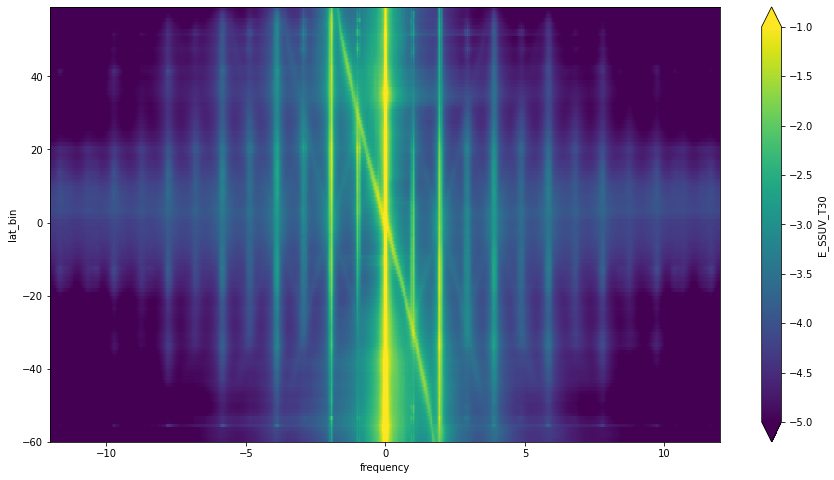

In [5]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T30_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV_T30).plot(x='frequency',vmin=-5,vmax=-1)

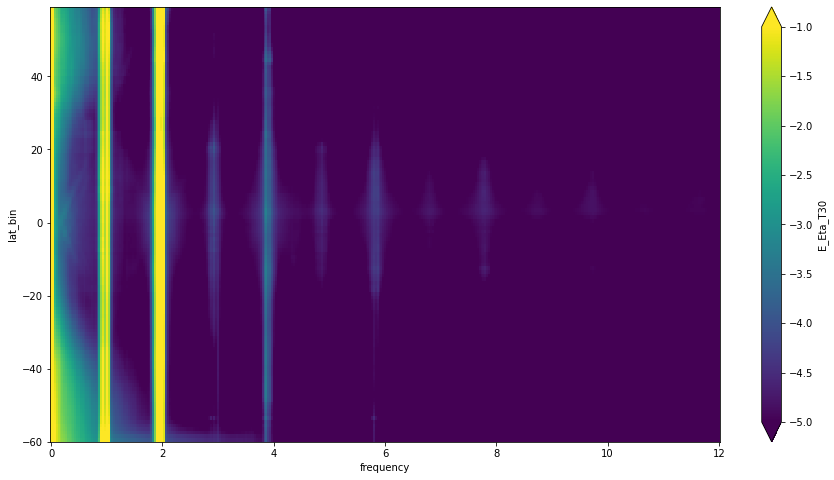

In [6]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/Eta_T30_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_Eta_T30).plot(x='frequency',vmin=-5,vmax=-1)

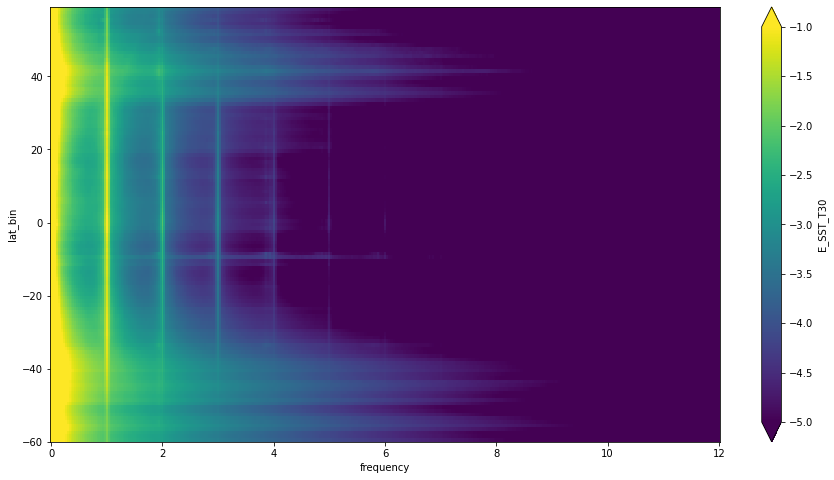

In [7]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SST_T30_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SST_T30).plot(x='frequency',vmin=-5,vmax=-1)

____________
## 2. lat x lon binning

In [4]:
V = ["SSUV","SST","Eta"]
T = ["T30", "T60", "T30_nomean", "T60_nomean"]

sub = 6
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # compute histogram with weights
        ds['lon'] = 0*ds[v]+ds.XC
        ds['lat'] = 0*ds[v]+ds.YC
        
        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds[v].load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )

        # get binned results
        E = (E/N).rename('E_%s'%(v)).rename({'lon_bin': 'lon','lat_bin': 'lat'})        
        # save
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))                

<SSUV_T30 - allready processed>
<SSUV_T60 - allready processed>
<SSUV_T30_nomean - allready processed>
<SSUV_T60_nomean - allready processed>
<SST_T30 - allready processed>
<SST_T60 - allready processed>
<SST_T30_nomean - allready processed>
<SST_T60_nomean - allready processed>
<Eta_T30 - allready processed>
<Eta_T60 - allready processed>
<Eta_T30_nomean - allready processed>
<Eta_T60_nomean - allready processed>


In [12]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon.zarr'))
E

<xarray.Dataset>
Dimensions:    (freq_time: 1440, lat: 179, lon: 359)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 85.5 86.5 87.5 88.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
Data variables:
    E_SSUV     (freq_time, lon, lat) float64 dask.array<chunksize=(180, 45, 23), meta=np.ndarray>

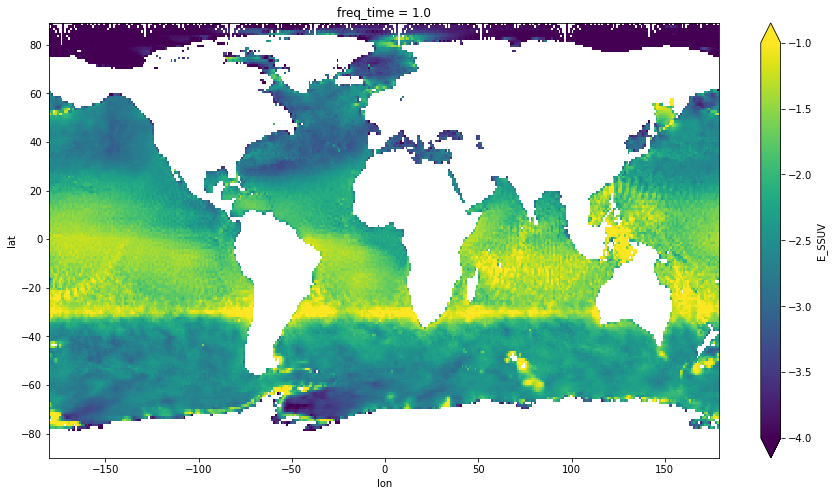

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(freq_time=1).plot(x='lon',y='lat',vmin=-4,vmax=-1)

_____________
## 3. lon x lat for band-integrated KE

In [18]:
#V = ["SSUV"]
V = ["Eta"]
V = ["SST"]

T = ["T30", "T60", "T30_nomean", "T60_nomean"]

sub = 4
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
bands = {'low': (0., .5), 'diurnal': (0.9, 1.1), 'semidiurnal': (1.9, 2.1), 'inertial':(0,0)}
    
for v in V:
    for t in T:

        # load spectra
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        ds = ds.load()
        
        # define delta omega, Near-inertial f
        domega = float(ds.freq_time[1]- ds.freq_time[0])
        f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds['YC']))
        f_cpd_llc = f_llc*86400/2./np.pi
        
        # binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        
        N = histogram(
                      ds.lon.rename('lon').load(), ds.lat.rename('lat').load(), 
                      bins=[lon_bins, lat_bins], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
 
        # band integral
        Eb = {}
        for b, bounds in bands.items():
            print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

            if b == "inertial":
                _E = ds[v].where((np.abs(ds.freq_time + f_cpd_llc)<=0.1), 
                                  drop=False,
                                )

            else:      
                _E = ds[v].where((np.abs(ds.freq_time)>=bounds[0]) & (np.abs(ds.freq_time)<=bounds[1]), 
                                  drop=False,
                                )
            _E = (domega*_E.sum('freq_time'))            

            E = histogram(
                          ds.lon.rename('lon').load(), ds.lat.rename('lat').load(),
                          bins=[lon_bins, lat_bins], 
                          weights=_E.load(),
                          dim=['i', 'j', 'face'], 
                          block_size=None
                         )

            E = (E/N).rename('E_%s'%(v))   
            Eb[b] = E.persist()

        # converts to single dataset and store:
        E = xr.concat(list(Eb.values()), 
                      dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                     )
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon_bands.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

Frequency band low, frequency bounds: 0.0-0.5 cpd
Frequency band diurnal, frequency bounds: 0.9-1.1 cpd
Frequency band semidiurnal, frequency bounds: 1.9-2.1 cpd
Frequency band inertial, frequency bounds: 0-0 cpd
<SST_T30 - allready processed>
Frequency band low, frequency bounds: 0.0-0.5 cpd
Frequency band diurnal, frequency bounds: 0.9-1.1 cpd
Frequency band semidiurnal, frequency bounds: 1.9-2.1 cpd
Frequency band inertial, frequency bounds: 0-0 cpd
<SST_T60 - allready processed>
Frequency band low, frequency bounds: 0.0-0.5 cpd
Frequency band diurnal, frequency bounds: 0.9-1.1 cpd
Frequency band semidiurnal, frequency bounds: 1.9-2.1 cpd
Frequency band inertial, frequency bounds: 0-0 cpd
<SST_T30_nomean - allready processed>
Frequency band low, frequency bounds: 0.0-0.5 cpd
Frequency band diurnal, frequency bounds: 0.9-1.1 cpd
Frequency band semidiurnal, frequency bounds: 1.9-2.1 cpd
Frequency band inertial, frequency bounds: 0-0 cpd
<SST_T60_nomean - allready processed>


In [7]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T30_lat_lon_bands.zarr'))
E

<xarray.Dataset>
Dimensions:         (frequency_band: 4, lat_bin: 119, lon_bin: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'low' 'diurnal' ... 'inertial'
  * lat_bin         (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bin         (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_SSUV          (frequency_band, lon_bin, lat_bin) float64 dask.array<chunksize=(2, 180, 119), meta=np.ndarray>

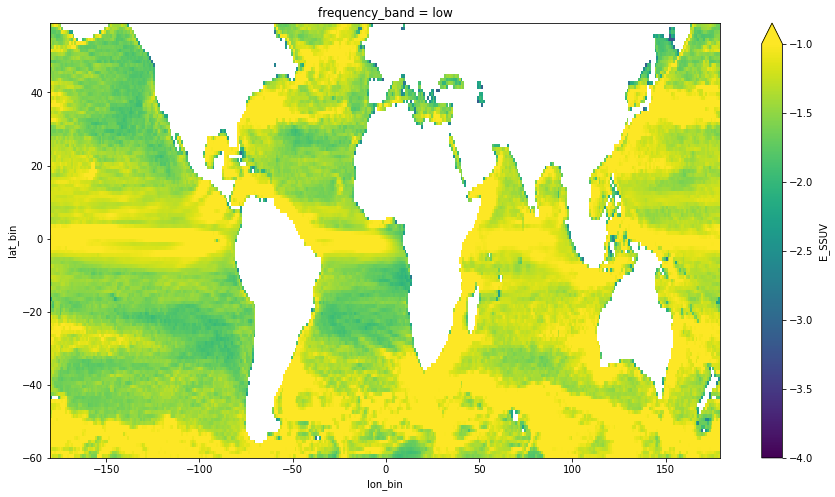

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency_band='low').plot(x='lon_bin',y='lat_bin',vmin=-4,vmax=-1)

## Close cluster

In [9]:
cluster.close()